In [1]:
import numpy as np
from numpy.linalg import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
clean_dataset_file = "datasets/global_datasetMin.txt"

### Chargement des données et encodage

In [3]:
with open(clean_dataset_file, "r") as f:
    clean_dataset = f.read().splitlines()

### Chargement du modèle d'encodage et encodage

In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load("models/w2vec_model_d300_global_Min")
dim = 300

def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [5]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 2min 4s, sys: 692 ms, total: 2min 4s
Wall time: 2min 4s


### Séparation jeu de données d'entraînement / jeu de données de test

In [6]:
dataset_train, dataset_test = train_test_split(dataset_encoded, test_size=0.2)

### Création du modèle

In [8]:
inputs = keras.Input(shape=(300,))
encode1 = keras.layers.Dense(128, activation="relu")(inputs)
encoded = keras.layers.Dense(2)(encode1)
decode1 = keras.layers.Dense(128, activation="relu")(encoded)
decoded = keras.layers.Dense(300, activation="tanh")(decode1)

encoder = keras.Model(inputs, encoded, name="encoder")
autoencoder = keras.Model(inputs, decoded, name="autoencoder")

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

### Entraînement du modèle

In [10]:
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath="models/ae_Min_3", verbose=0, save_best_only=True)

In [11]:
autoencoder.fit(dataset_train, dataset_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(dataset_test, dataset_test),
                callbacks=[savemodel_callback])

2022-05-29 12:33:22.596542: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 690456000 exceeds 10% of free system memory.
2022-05-29 12:33:23.000538: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 690456000 exceeds 10% of free system memory.
2022-05-29 12:33:23.271272: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 690456000 exceeds 10% of free system memory.
2022-05-29 12:33:23.434270: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 690456000 exceeds 10% of free system memory.


Epoch 1/30
2248/2248 [==============================] - ETA: 0s - loss: 0.0015

2022-05-29 12:33:31.469809: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/ae_Min_3/assets
2248/2248 [==============================] - 8s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/30
2248/2248 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/30
2248/2248 [============

### Quelques tests sur les résultats

In [12]:
def cosine_similarity(a, b):
    return np.dot(a,b)/(norm(a)*norm(b))

On a une grande similarité entre l'entrée et la sortie de l'autoencodeur

In [13]:
n = 42
cosine_similarity(autoencoder.predict(dataset_encoded[n:n+1]), dataset_encoded[n])

array([0.99601895])

Les composantes d'un vecteur d'entrée et de sortie sont les mêmes à quelques centièmes près

In [14]:
autoencoder.predict(dataset_encoded[n:n+1])[0,:10]

array([ 0.16202307,  0.44931415,  0.27600402,  0.10396709,  0.14309531,
        0.03420793, -0.17850538,  0.3276509 , -0.11158871, -0.22409286],
      dtype=float32)

In [15]:
dataset_encoded[n,:10]

array([ 0.17151119,  0.49289277,  0.29393384,  0.08964436,  0.16869645,
        0.03951823, -0.19311355,  0.32082355, -0.12117271, -0.25077292])

### Visualisation du dataset ainsi encodé en deux dimensions

In [16]:
%%time
two_dim_dataset = encoder.predict(dataset_encoded)

2022-05-29 12:37:30.613834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 863070000 exceeds 10% of free system memory.


CPU times: user 22 s, sys: 2.08 s, total: 24 s
Wall time: 15.1 s


In [17]:
b = two_dim_dataset.T

In [18]:
import matplotlib.pyplot as plt

In [19]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams["lines.markersize"] = 3
plt.rcParams["scatter.marker"] = '.'

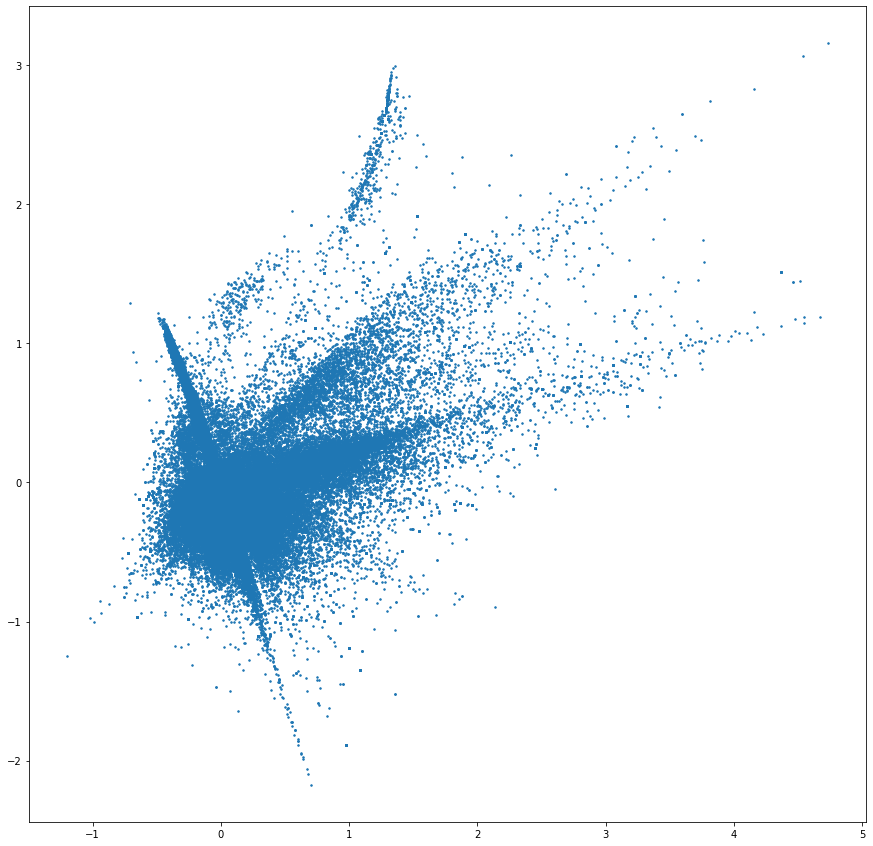

In [20]:
plt.scatter(b[0], b[1])
plt.show()

### Comparaison avec PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [22]:
%%time
#On crée une version en deux dimensions de notre jeu de données
pca_two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 48.7 s, sys: 11.7 s, total: 1min
Wall time: 9.63 s


In [23]:
pca = pca_two_dim_dataset.T

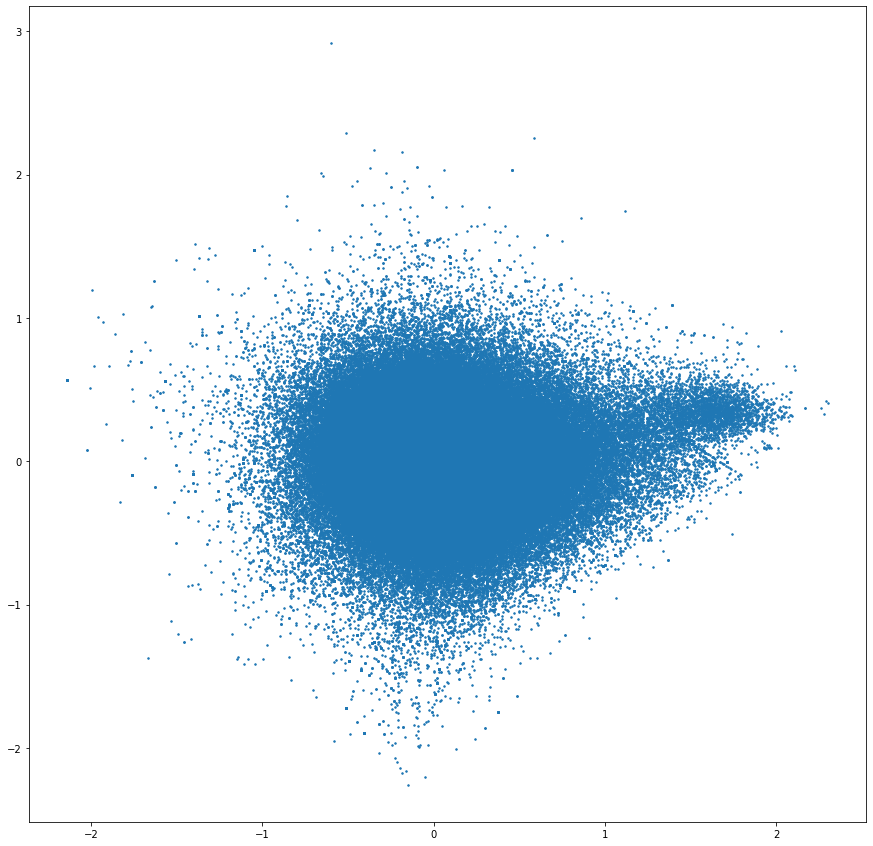

In [24]:
plt.scatter(pca[0], pca[1])
plt.show()